# Welcome and have fun learning Logistic Regession with plug and play Neural Network
### Lets just brute force NN for now.
<blockquote style="margin-right:auto; margin-left:auto; padding: 1em; margin:24px;">
    <strong>Fork This Notebook!</strong><br>
Create your own editable copy of this notebook by clicking on the <strong>Copy and Edit</strong> button in the top right corner.
</blockquote>

**Notes:**
Run time -
4 hours and 31 minutes 4000000 samples
3318.3s 395712 samples
4375.7s 1468136 samples
12905.1s 2262087 samples
5555.3s - GPU 2262087 samples

## Imports and Configuration ##

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler, PowerTransformer
le = LabelEncoder()
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold

import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import gc
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-dec-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-dec-2021/train.csv
/kaggle/input/tabular-playground-series-dec-2021/test.csv


In [2]:
# -----------------------------------------------------------------
# Some parameters to config 

EPOCHS = 362      # Does not matter with Early stopping.
BATCH_SIZE = 2048 # large enough to fit RAM
ACTIVATION = 'selu' # swish relu selu
FOLDS = 10        # Only 5 or 10.
LEARNING_RATE = 0.000965713 # Optimal lr is about half the maximum lr
LR_FACTOR = 0.5   # LEARNING_RATE * LR_FACTOR = New Learning rate on ReduceLROnPlateau
RLRP_PATIENCE = 7 # Learning Rate reduction on ReduceLROnPlateau
ES_PATIENCE = 22  # Early stopping
DROPOUT = 0.15    # Act like L1 L2 regulator.

# The dataset is too huge for free contrainer. Sampling it for speed run!
SAMPLE = 2262087  # quick test y counts [1468136, 2262087, 195712, 377, 1, 11426, 62261]  # 4000000 total rows
VALIDATION_SPLIT = 0.15 # Only used to min dataset for quick test
MAX_TRIAL = 3     # speed trial any% Not used here

RANDOM_STATE = 42
VERBOSE = 0

# Admin
ID = "Id"         # Id id x X index
INPUT = "../input/tabular-playground-series-dec-2021"

## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. We'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll impute `0` for missing numeric values and `"None"` for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise.

In [3]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

## Reduce Memory usage

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

# Feature Engineering
These features are borrowed from https://www.kaggle.com/gulshanmishra/tps-dec-21-tensorflow-nn-feature-engineering

In [5]:
def feature_engineer(df):
    # Euclidean distance to Hydrology
    df["ecldn_dist_hydrlgy"] = (df["Horizontal_Distance_To_Hydrology"]**2 + df["Vertical_Distance_To_Hydrology"]**2)**0.5

    # Manhhattan distance to Hydrology
    df["mnhttn_dist_hydrlgy"] = np.abs(df["Horizontal_Distance_To_Hydrology"]) + np.abs(df["Vertical_Distance_To_Hydrology"])

    df.loc[df["Aspect"] < 0, "Aspect"] += 360
    df.loc[df["Aspect"] > 359, "Aspect"] -= 360
    # Transform Cyclic Ordinal attributes to X y coordinates. 0 degree will be group with 359 degree etc.
    df['AspectX'] = np.sin(2.*np.pi*df.Aspect/360)
    df['Aspecty'] = np.cos(2.*np.pi*df.Aspect/360)

    soil_features = [x for x in df.columns if x.startswith("Soil_Type")]
    df["soil_type_count"] = df[soil_features].sum(axis=1)

    wilderness_features = [x for x in df.columns if x.startswith("Wilderness_Area")]
    df["wilderness_area_count"] = df[wilderness_features].sum(axis=1)

#     df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] += 360
#     df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] += 360
#     df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] += 360
#     df['Hillshade_9am_AspectX'] = np.sin(2.*np.pi*df.Hillshade_9am/360)
#     df['Hillshade_9am_Aspecty'] = np.cos(2.*np.pi*df.Hillshade_9am/360)
#     df['Hillshade_Noon_AspectX'] = np.sin(2.*np.pi*df.Hillshade_Noon/360)
#     df['Hillshade_Noon_Aspecty'] = np.cos(2.*np.pi*df.Hillshade_Noon/360)
#     df['Hillshade_3pm_AspectX'] = np.sin(2.*np.pi*df.Hillshade_3pm/360)
#     df['Hillshade_3pm_Aspecty'] = np.cos(2.*np.pi*df.Hillshade_3pm/360)
#     df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
#     df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
#     df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
#     df.loc[df["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
#     df.loc[df["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
#     df.loc[df["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
    
#     df.drop(["Aspect", "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"], axis=1, inplace=True)
    
    return df

In [6]:
from pathlib import Path
def load_data():
    # Read data
    data_dir = Path(INPUT)
    df_train = pd.read_csv(data_dir / "train.csv", index_col=ID)
    df_test = pd.read_csv(data_dir / "test.csv", index_col=ID)
    # Merge the splits so we can process them together
#     df = pd.concat([df_train, df_test])
    # Preprocessing
#     df = clean(df)
#     df = encode(df)
    df_train = impute(df_train)
    df_test = impute(df_test)
    df_train = feature_engineer(df_train)
    df_test = feature_engineer(df_test)
    df_train = reduce_mem_usage(df_train)
    df_test = reduce_mem_usage(df_test)
    
    # Reform splits
#     df_train = df.loc[df_train.index, :]
#     df_test = df.loc[df_test.index, :]
    return df_train, df_test

# Load Data #

And now we can call the data loader and get the processed data splits:

In [7]:
train_data, test_data = load_data()

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Mem. usage decreased to 335.69 Mb (82.3% reduction)
Mem. usage decreased to 82.97 Mb (82.2% reduction)


In [8]:
column_y = train_data.columns.difference(test_data.columns)[0] # column_y target_col

In [9]:
#customized XY TBR
idx = train_data[train_data[column_y] == 5].index
train_data.drop(idx, axis=0, inplace=True)
cols = ["Soil_Type7", "Soil_Type15"]
train_data.drop(cols, axis=1, inplace=True)
test_data.drop(cols, axis=1, inplace=True)

In [10]:
X = train_data.drop(columns=column_y)
y = train_data[[column_y]]

X_test = test_data.iloc[:,:]

gc.collect()

63

## For quick test
y

(array([1, 2, 3, 4, 5, 6, 7]),
 
 array([1468136, 2262087,  195712,     377,       1,   11426,   62261]))
 
TomekLinks
(array([1, 2, 3, 4, 5, 6, 7]),

 array([1390684, 2169226,  155218,     218,       1,    7627,   38757]))

# Undersampling

In [11]:
# Check NA
missing_val = X.isnull().sum()
print(missing_val[missing_val > 0])

from sklearn.model_selection import train_test_split 
# For small testing batch
# X, X_val, y, y_val = train_test_split(X, y, train_size = VALIDATION_SPLIT, random_state = RANDOM_STATE)
# X = X.sample(n=SAMPLE, random_state=RANDOM_STATE)
# y = y.sample(n=SAMPLE, random_state=RANDOM_STATE)
# X_test = X_test.sample(n=SAMPLE, random_state=RANDOM_STATE)

# undersample = TomekLinks(sampling_strategy='auto') #, random_state=RANDOM_STATE not minority RandomUnderSampler
# X_under, y_under = undersample.fit_resample(X, y)

Series([], dtype: int64)


In [12]:
# Uncomment to peek at samples across all targets.
small_sampling = train_data.groupby(column_y).apply(lambda s: s.sample(min(len(s), 5)))
small_sampling

Elevation  Aspect  Slope  \
Cover_Type Id                                  
1          392451        3289     322     14   
           1684831       3182      27     20   
           3568284       3256     339     23   
           3111588       3279      13     37   
           262582        3260     177     20   
2          2305867       2608      93     12   
           1015695       2664      45     14   
           277212        2975     141      4   
           3454613       2699     315     25   
           321696        2865     220     21   
3          870973        2412      80     21   
           3710061       2497     118     15   
           3159329       2741     285     23   
           2585691       2603      63      6   
           3504497       2110     117     34   
4          1769028       2247      59     19   
           3856703       1961     249     13   
           3100674       2159      51      7   
           2762964       2188     105     23   
           3080302       2206      88     20   
6          3819674       2414     307     24   
           3874658       2373      15     17   
           2286583       2368     249     17   
           1177479       2657      54      6   
           1867745       1885     113     26   
7          2513242       3402     162      3   
           163331        3328      80     19   
           1870551       3333     305     19   
           3450988       3398     295     24   
           3445437       3452     138     14   

                    Horizontal_Distance_To_Hydrology  \
Cover_Type Id                                          
1          392451                                775   
           1684831                                38   
           3568284                               105   
           3111588                              1143   
           262582                                104   
2          2305867                              1113   
           1015695                                95   
           277212                                 33   
           3454613                               165   
           321696                                369   
3          870973                                296   
           3710061                               759   
           3159329                               547   
           2585691                               237   
           3504497                                50   
4          1769028                                 0   
           3856703                                35   
           3100674                                30   
           2762964                               394   
           3080302                               -11   
6          3819674                               422   
           3874658                               170   
           2286583                               229   
           1177479                               199   
           1867745                                30   
7          2513242                               188   
           163331                                177   
           1870551                               145   
           3450988                               729   
           3445437                               414   

                    Vertical_Distance_To_Hydrology  \
Cover_Type Id                                        
1          392451                               23   
           1684831                             113   
           3568284                               5   
           3111588                              79   
           262582                                2   
2          2305867                              94   
           1015695                              29   
           277212                              244   
           3454613                              33   
           321696                               37   
3          870973                         

In [13]:
sampling_key, sampling_count = np.unique(y, return_counts=True)
sampling_count[sampling_count > SAMPLE] = SAMPLE
zip_iterator = zip(sampling_key, sampling_count)
sampling_params = dict(zip_iterator)

In [14]:
# not minority
undersample = RandomUnderSampler(
    sampling_strategy=sampling_params, random_state=RANDOM_STATE)

X, y = undersample.fit_resample(X, y)

In [15]:
np.unique(y, return_counts=True)

(array([1, 2, 3, 4, 6, 7], dtype=int8),
 array([1468136, 2262087,  195712,     377,   11426,   62261]))

y to categorical

In [16]:
# Prepare for multiclass classification tf.keras.utils.to_categorical(le.fit_transform(y[column_y])) categorical_crossentropy
y_cat = le.fit_transform(y[column_y])

In [17]:
# X_num = X.select_dtypes(include=[np.number])
# X_cat = X.select_dtypes(include=['object'])

In [18]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()

# for i in range(1,5):
#     X[f'Wilderness_Area{i}'] = le.fit_transform(Xf'Wilderness_Area{i}'])
#     X_test[f'Wilderness_Area{i}'] = le.fit_transform(X_test[f'Wilderness_Area{i}'])
# for i in range(1,41):
#     X[f'Soil_Type{i}'] = le.fit_transform(X[f'Soil_Type{i}'])
#     X_test[f'Soil_Type{i}'] = le.fit_transform(X_test[f'Soil_Type{i}'])

# Scaler transformer
By using RobustScaler(), we can remove the outliers
![](https://github.com/furyhawk/kaggle_practice/blob/main/images/Scalers.png?raw=true)

In [19]:
transformer_all_cols = make_pipeline(
    RobustScaler(),
#     StandardScaler(),
#     MinMaxScaler(feature_range=(0, 1))
)

preprocessor = make_column_transformer(
    (transformer_all_cols, X.columns[:]),
)

# Train Model and Create Submissions #

Once you're satisfied with everything, it's time to create your final predictions! This cell will:
- use the best trained model to make predictions from the test set
- save the predictions to a CSV file

In [20]:
def load_model():
    
    early_stopping = EarlyStopping(
        patience=ES_PATIENCE,
        min_delta=0,
        monitor='val_acc',
        mode='max',
        restore_best_weights=True,       
        baseline=None,
        verbose=VERBOSE,
    )
    plateau = ReduceLROnPlateau(
            patience=RLRP_PATIENCE,
            factor=LR_FACTOR,
            monitor='val_loss', 
            mode='min',
            verbose=VERBOSE,
    )

# -----------------------------------------------------------------
# Model , kernel_initializer="lecun_normal"

    model = keras.Sequential([
    layers.BatchNormalization(input_shape = [X.shape[-1]], name='input'),
    layers.Dense(300, kernel_initializer="lecun_normal", activation=ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(200, kernel_initializer="lecun_normal", activation=ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(100, kernel_initializer="lecun_normal", activation=ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(50, kernel_initializer="lecun_normal", activation=ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(le.classes_.shape[-1], activation = 'softmax'), #y_cat.shape[-1]
    ])

# -----------------------------------------------------------------
# sparse_categorical_crossentropy
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy', # sparse_categorical_crossentropy categorical_crossentropy
        metrics=['acc'],
    )
    
    return model, early_stopping, plateau

# Kfold

In [21]:
preds_valid_f = {}
preds_test = []
total_acc = []
f_scores = []

kf = StratifiedKFold(n_splits=FOLDS,random_state=RANDOM_STATE,shuffle=True)

In [22]:
X_train_transformed = preprocessor.fit_transform(X)
X_test = preprocessor.transform(test_data)

In [23]:
for fold,(train_index, valid_index) in enumerate(kf.split(X=X, y=y.Cover_Type)):

    X_train, X_valid = X_train_transformed[train_index], X_train_transformed[valid_index]
    y_train, y_valid = y_cat[train_index], y_cat[valid_index]

    #   --------------------------------------------------------  
    # Preprocessing
    index_valid = valid_index.tolist()
#     index_valid  = X_valid.index.tolist()
#     X_train = preprocessor.fit_transform(X_train)
#     X_valid = preprocessor.transform(X_valid)
    
    #  ----------------------------------------------------------    
    # Model
    model, early_stopping, plateau  = load_model()

    history = model.fit( X_train, y_train,
                validation_data = (X_valid, y_valid),
                batch_size      = BATCH_SIZE, 
                epochs          = EPOCHS,
                callbacks       = [early_stopping, plateau],
                shuffle         = True,
                verbose         = 0
              )
    
    #  ----------------------------------------------------------
    #  oof
    preds_valid = model.predict(X_valid, batch_size=BATCH_SIZE)
    
    #  ----------------------------------------------------------
    #  test dataset predictions for submission np.argmax(, axis=1) + 1
    preds_test.append( le.inverse_transform(np.argmax(model.predict(X_test, batch_size=BATCH_SIZE), axis=1)) )

    #  ----------------------------------------------------------
    #  Saving  scores to plot the end  
    scores = pd.DataFrame(history.history)
    scores['folds'] = fold
    if fold == 0:
        f_scores = scores
        model.summary()
    else: 
        f_scores = pd.concat([f_scores, scores], axis  = 0)

    #  ----------------------------------------------------------
    #  concatenating valid preds
    preds_valid_f.update(dict(zip(index_valid, le.inverse_transform(np.argmax(preds_valid, axis=1)))))
    # Getting score for a fold model
    fold_acc = accuracy_score(y.iloc[valid_index].Cover_Type, le.inverse_transform(np.argmax(preds_valid, axis=1)))
    print(f"Fold {fold} accuracy_score: {fold_acc}")

    # Total acc
    total_acc.append(fold_acc)
    
    del model
    gc.collect()

print(f"mean accuracy_score: {np.mean(total_acc)}, std: {np.std(total_acc)}")

2021-12-07 00:03:32.313252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 00:03:32.419799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 00:03:32.420570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 00:03:32.421933: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (BatchNormalization)   (None, 58)                232       
_________________________________________________________________
dense (Dense)                (None, 300)               17700     
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

2021-12-07 00:11:20.849609: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 835199768 exceeds 10% of free system memory.
2021-12-07 00:11:21.698622: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 835199768 exceeds 10% of free system memory.


Fold 1 accuracy_score: 0.965175


2021-12-07 00:18:49.129128: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 835199768 exceeds 10% of free system memory.


Fold 2 accuracy_score: 0.96284
Fold 3 accuracy_score: 0.9610775
Fold 4 accuracy_score: 0.96052
Fold 5 accuracy_score: 0.9595
Fold 6 accuracy_score: 0.9606625
Fold 7 accuracy_score: 0.96159
Fold 8 accuracy_score: 0.96314
Fold 9 accuracy_score: 0.9619449048622621
mean accuracy_score: 0.961609740486226, std: 0.0016537383209955811


# Evaluation

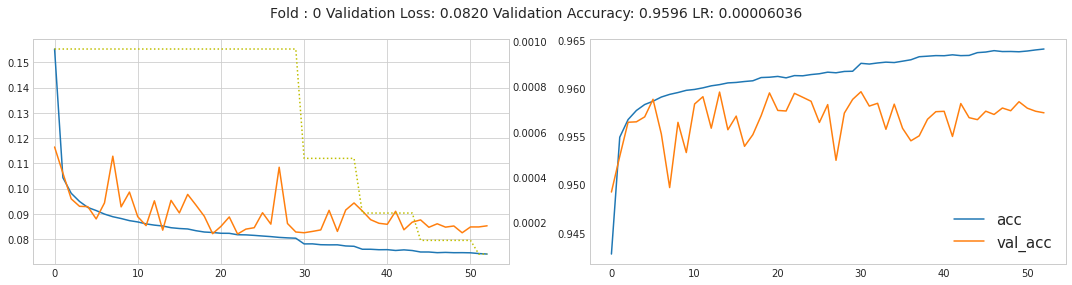

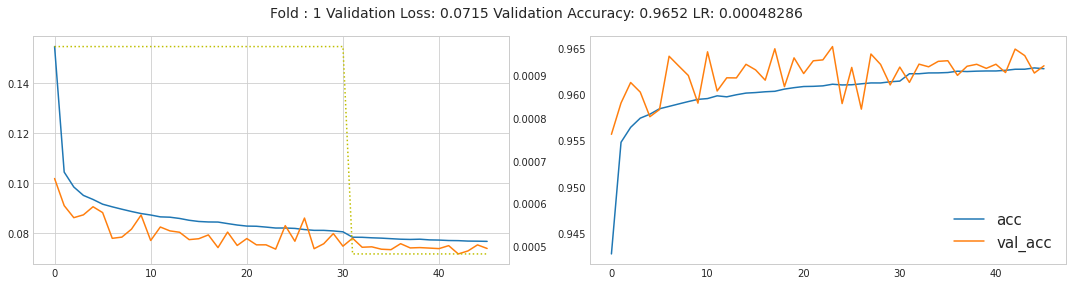

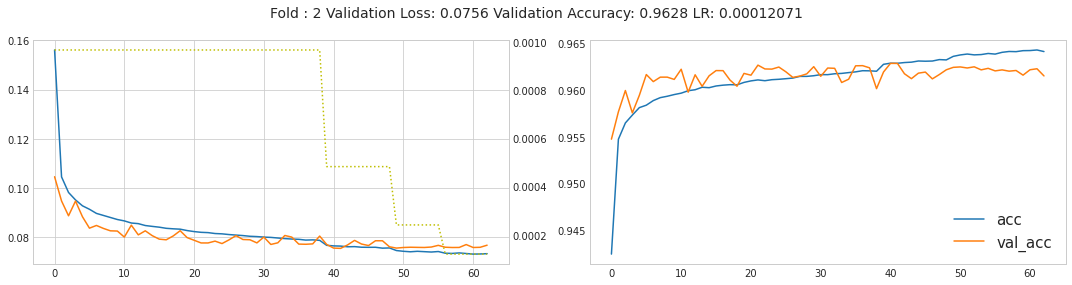

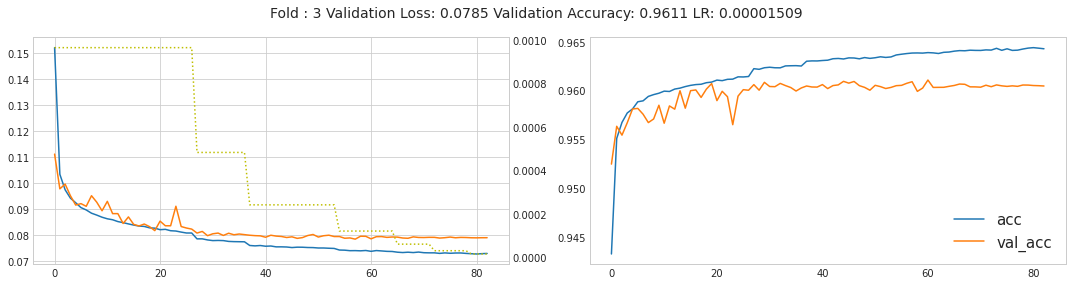

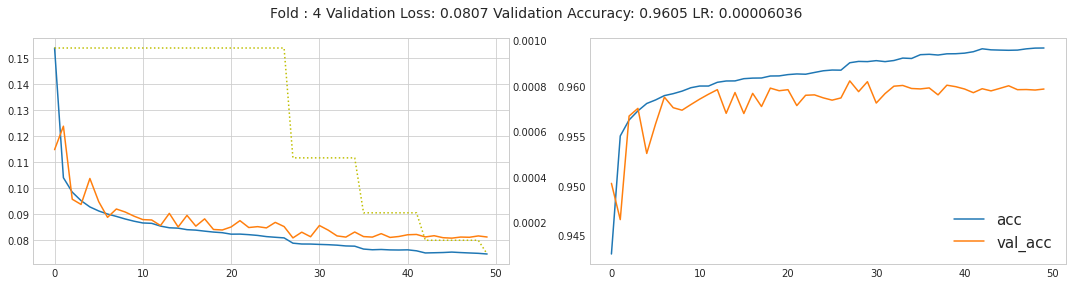

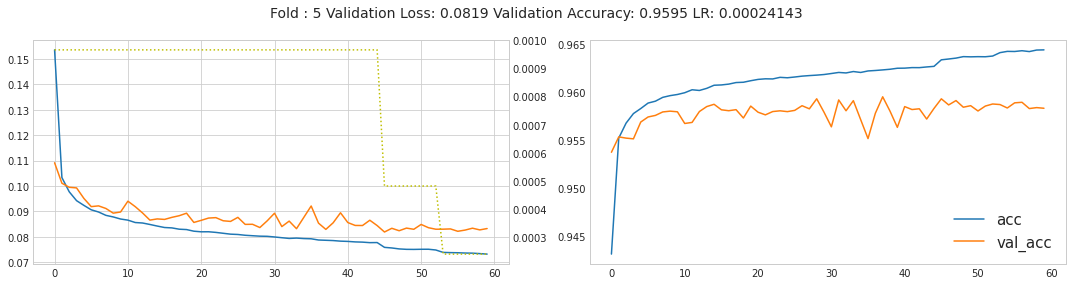

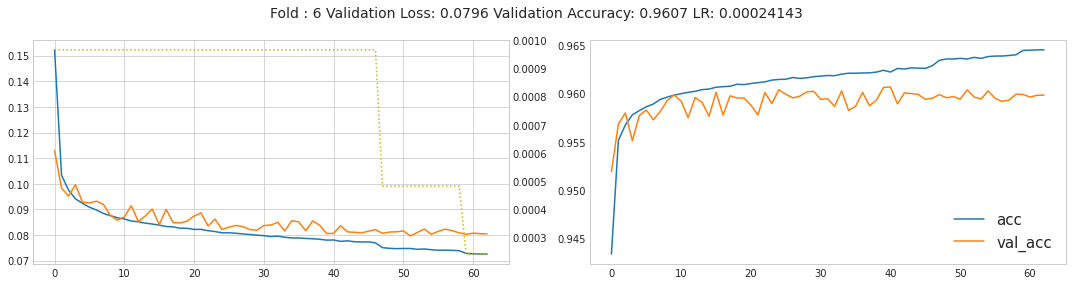

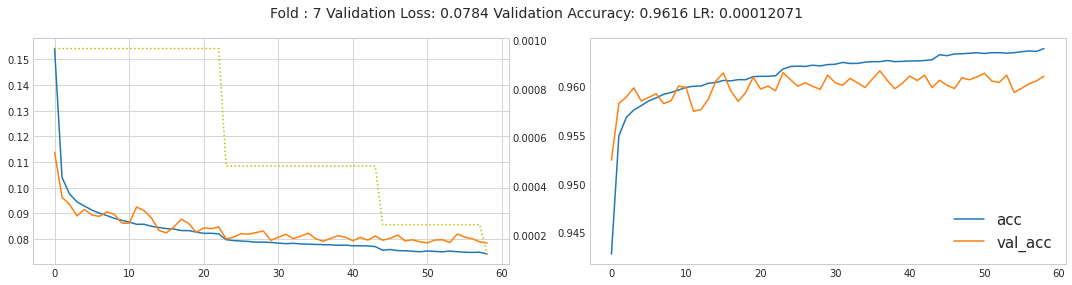

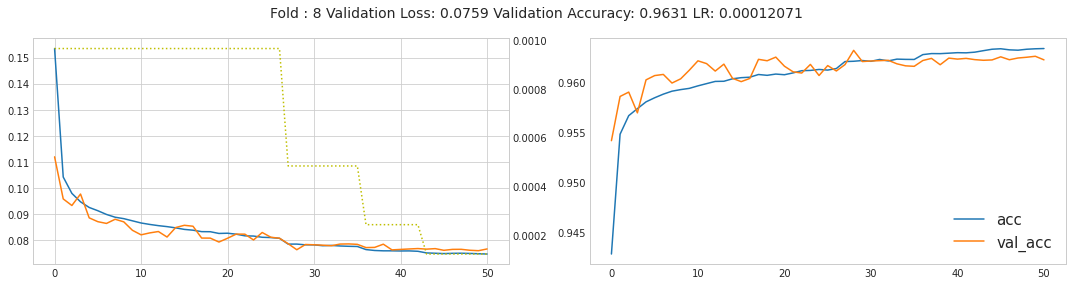

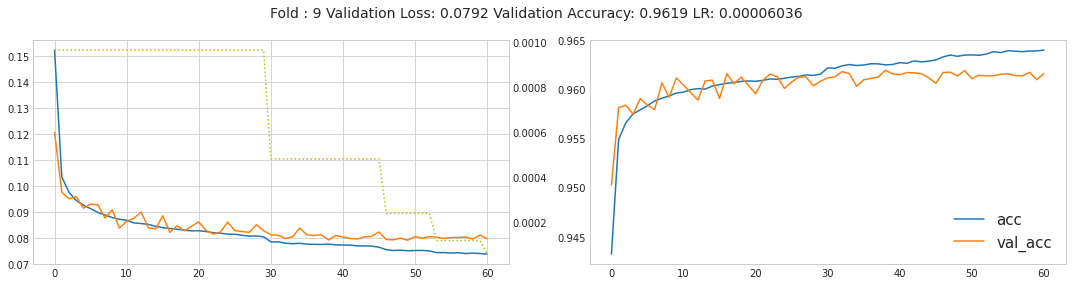

In [24]:
def plot_acc(f_scores):
    for fold in range(f_scores['folds'].nunique()):
        history_f = f_scores[f_scores['folds'] == fold]

        fig, ax1 = plt.subplots(1, 2, tight_layout=True, figsize=(15,4))

        fig.suptitle('Fold : '+ str(fold) +
                     " Validation Loss: {:0.4f}".format(history_f['val_loss'].min()) +
                     " Validation Accuracy: {:0.4f}".format(history_f['val_acc'].max()) +
                     " LR: {:0.8f}".format(history_f['lr'].min())
                     , fontsize=14)

        plt.subplot(1,2,1)
        plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])
        plt.gca().twinx().plot(history_f.loc[:, ['lr']], 'y:') # default color is same as first ax
        plt.legend(fontsize=15)
        plt.grid()

        plt.subplot(1,2,2)
        plt.plot(history_f.loc[:, ['acc', 'val_acc']],label= ['acc', 'val_acc'])
        plt.legend(fontsize=15)
        plt.grid()

plot_acc(f_scores)

## Confusion matrix

In [25]:
def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis=1),
        'precision': cm / cm.sum(axis=0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(15,5))
    ax = ax.flatten()

    mask = (np.eye(cm.shape[0]) == 0) * 1

    for idx, (name, matrix) in enumerate(metrics.items()):

        ax[idx].set_title(name)

        sns.heatmap(
            data=matrix,
            cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar=False,
            mask=mask,
            lw=0.25,
            annot=True,
            fmt='.2f',
            ax=ax[idx]
        )
    sns.despine()

In [26]:
oof_y_hat = []
for key, value in sorted(preds_valid_f.items()):
    oof_y_hat.append(value)

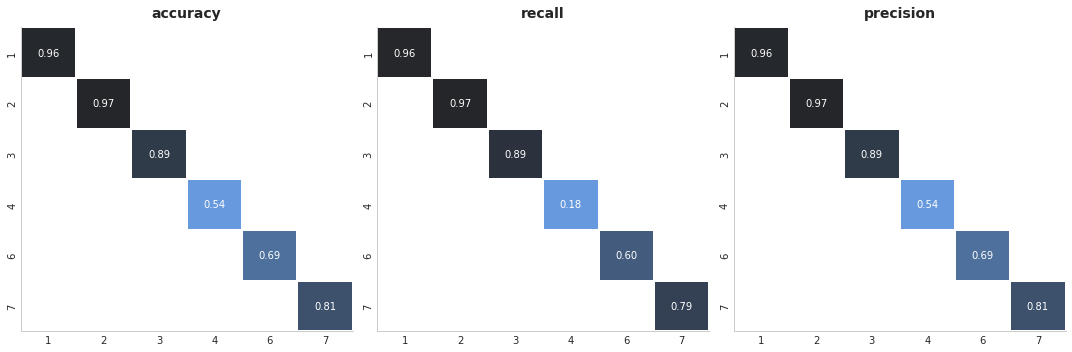

In [27]:
# create confusion matrix, calculate accuracy,recall & precision
cm = pd.DataFrame(data=confusion_matrix(y, oof_y_hat, labels=le.classes_), index=le.classes_, columns=le.classes_)
plot_cm(cm)

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores. Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

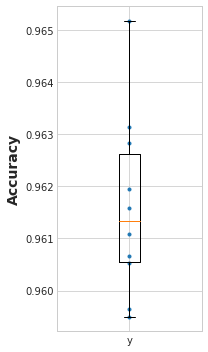

In [28]:
plt.figure(figsize=(3, 5))
plt.plot([1]*10, total_acc, ".")
plt.boxplot([total_acc], labels=("y"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

# Submission

In [29]:
sub = pd.read_csv(INPUT + '/sample_submission.csv')
sub[column_y] = (stats.mode(preds_test)[0][0]) # preds_test[FOLDS-1] # argmax reverse of to_categorical sub[column_y] = (np.argmax(sum(preds_test), axis=1) + 1)
sub.to_csv('submission.csv', index=False)
sub

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2
...,...,...
999995,4999995,2
999996,4999996,1
999997,4999997,2
999998,4999998,1


In [30]:
np.unique(sub[column_y], return_counts=True)

(array([1, 2, 3, 4, 6, 7], dtype=int8),
 array([387738, 512811,  77988,    121,   5835,  15507]))

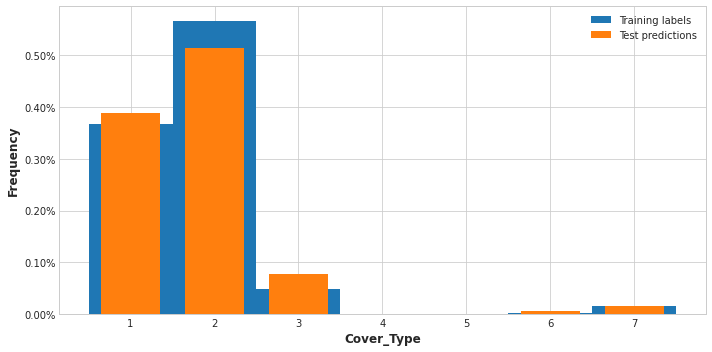

In [31]:
# Plot the distribution of the test predictions vs training set
plt.figure(figsize=(10,5))
plt.hist(train_data[column_y], bins=np.linspace(0.5, 7.5, 8), density=True, label='Training labels')
plt.hist(sub[column_y], bins=np.linspace(0.5, 7.5, 8), density=True, rwidth=0.7, label='Test predictions')
plt.xlabel('Cover_Type')
plt.ylabel('Frequency')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.show()


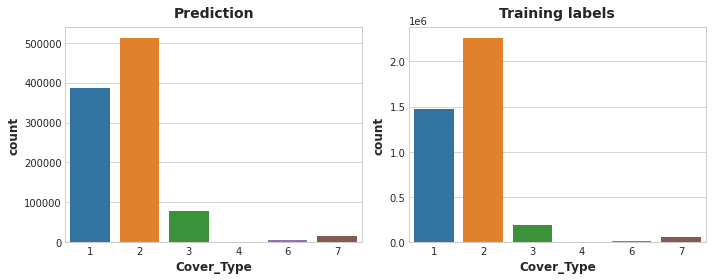

In [32]:
# Plot the distribution of the test predictions
fig, ax =plt.subplots(1,2,figsize=(10,4))
sns.countplot(x = sub[column_y], ax=ax[0], orient="h").set_title("Prediction")
# Plot the distribution of the training set
sns.countplot(x = train_data[column_y], ax=ax[1], orient="h").set_title("Training labels")
fig.show()

keys_list, values_list = np.unique(my_list, return_counts=True)keys_list, values_list = np.unique(my_list, return_counts=True)To submit these predictions to the competition, follow these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

# Next Steps #

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.

Be sure to check out [other users' notebooks](https://www.kaggle.com/c/tabular-playground-series-dec-2021/code) in this competition. You'll find lots of great ideas for new features and as well as other ways to discover more things about the dataset or make better predictions. There's also the [discussion forum](https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion), where you can share ideas with other Kagglers.

Have fun Kaggling!

In [33]:
# np.array(preds_test).shape